In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import torch
from loader import *
import matplotlib.pyplot as plt
import h5py
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
import matplotlib.transforms as mtransforms
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.ticker import MaxNLocator
from utils import *
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

logging.disable(logging.CRITICAL)

# Figure 8: Heuristic vs. optimized PV for what the PV source term concerns

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

In [4]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = False
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_min_train = PV_optimized_train.min()
PV_optimized_max_train = PV_optimized_train.max()
PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

(241519, 21)


### Heuristic PV

In [5]:
PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]
PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)

PV_Xu_train_source = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
PV_Xu_train_source = PV_Xu_train_source.to_numpy().reshape(-1,1)

Output_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']

output_matrix = state_space_train[Output_species].to_numpy()

## Visualize PV source term

C:\Windows\Temp\ipykernel_32304\3121685741.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


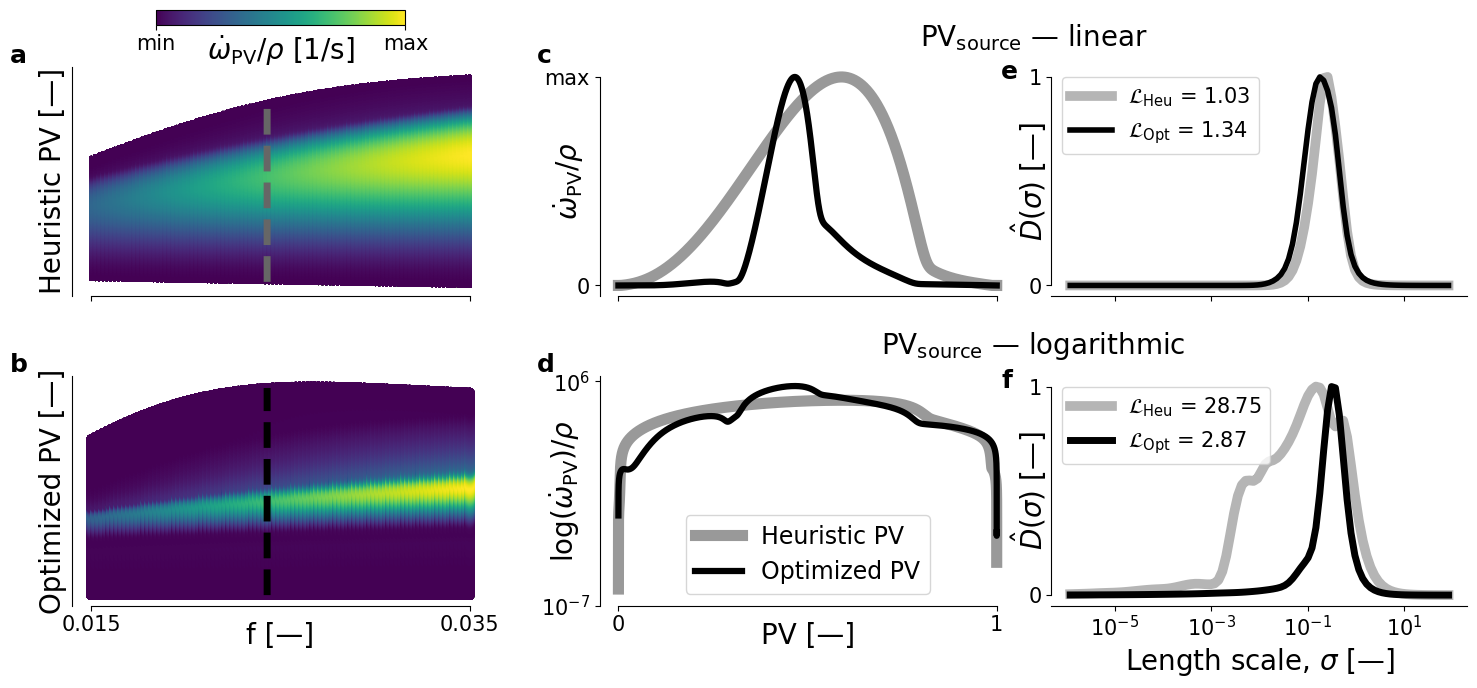

In [77]:
def add_panel_label(ax, label, x_offset=-0.12, y_offset=1.18, fontsize=18):
    ax.text(
        x_offset, y_offset,
        label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
        va="top",
        ha="left",
        clip_on=False
    )


save = True
pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
name = "Figure 8 - PV source term - optimized vs heuristic PV - 2s - no spines - labels.png"

fig = plt.figure(figsize=(18, 7))
gs = gridspec.GridSpec(2, 19, figure=fig, wspace = 0.9, hspace=0.35)

# Left column block (cols 0–2)
ax00 = fig.add_subplot(gs[0, 0:6])
ax10 = fig.add_subplot(gs[1, 0:6])

# Middle column block (cols 5–7)
ax01 = fig.add_subplot(gs[0, 7:13])
ax11 = fig.add_subplot(gs[1, 7:13])

# Right column block (cols 8–10)
ax02 = fig.add_subplot(gs[0, 13:19])
ax12 = fig.add_subplot(gs[1, 13:19])


#################################
# Top left - Heuristic PV
#################################
ax00.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=PV_Xu_train_source)

# Test state space
idxTraj = 4
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    PV_heuristic_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]

ax00.plot(np.full(PV_heuristic_test.shape[0], mixture_fractions_test[idxTraj]),
              PV_heuristic_test, color=str(0.4), linestyle="--", linewidth=5)

ax00.set_xticks([0.015, 0.035])
ax00.set_xticklabels([])
ax00.tick_params(axis='x', labelsize=15)
ax00.set_ylabel("Heuristic PV [\u2014]", fontsize=20)
ax00.set_yticks([])
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

ax00.spines["bottom"].set_bounds(0.015, 0.035)

pos_top = ax00.get_position()
pos_bottom = ax10.get_position()

left = pos_top.x0
right = pos_top.x1
lenX = right - left
top = pos_top.y1

cbar_height = 0.021
cbar_padding = 0.06

cax = fig.add_axes([
    left + lenX*0.2,
    top + cbar_padding,
    0.6*lenX,
    cbar_height
])

cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]',
               fontsize=20, labelpad=-15)

vmin = PV_optimized_source_train.min()
vmax = PV_optimized_source_train.max()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=15)


#################################
# Bottom left - Optimized PV
#################################


with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

ax10.plot(np.full(PV_optimized_test.shape[0], mixture_fractions_test[idxTraj]),
                 PV_optimized_test, color="k", linestyle = "--", linewidth=5)

sc = ax10.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis')

ax10.set_xlabel("f [\u2014]", fontsize=20, labelpad=-10)
ax10.set_xticks([0.015, 0.035])
ax10.tick_params(axis='x', labelsize=15)
ax10.set_ylabel("Optimized PV [\u2014]", fontsize=20)
ax10.set_yticks([])
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)

ax10.spines["bottom"].set_bounds(0.015, 0.035)

#################################
# Top middle - PVsource trajectory
#################################
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min()) / (PV_optimized_test.max() - PV_optimized_test.min())

    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

first_negative_idx = np.where(PV_Xu_source_test < 0)[0][0]
ax01.plot(PV_Xu_test[:first_negative_idx], PV_Xu_source_test[:first_negative_idx]/PV_Xu_source_test[:first_negative_idx].max(),
              linewidth=8, color=str(0.6), label="Heuristic PV")

first_negative_idx = np.where(PV_optimized_source_test < 0)[0][0]
ax01.plot(PV_optimized_test[:first_negative_idx], PV_optimized_source_test[:first_negative_idx]/PV_optimized_source_test[:first_negative_idx].max(),
              linewidth=4.5, color="k", linestyle="-", label="Optimized PV")

ax01.set_ylabel(r'$\dot{\omega}_{\mathrm{PV}} / \rho$', fontsize=20, labelpad = -30)
ax01.set_xticks([0, 1])
ax01.set_xticklabels([])
ax01.tick_params(axis='x', labelsize=15)
ax01.tick_params(axis='y', labelsize=15)
#ax01.set_title( r"$\mathit{linear}$", fontsize=20)
ax01.set_yticks([0, 1])
ax01.set_yticklabels(["0", "max"])

ax01.spines["bottom"].set_bounds(0, 1)
ymin, ymax = ax01.get_ylim()
ax01.spines["left"].set_bounds(ymin, 1)

#################################
# Bottom middle - logPVsource trajectory
#################################
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min()) / (PV_optimized_test.max() - PV_optimized_test.min())

    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

first_negative_idx = np.where(PV_Xu_source_test < 0)[0][0]
ax11.plot(PV_Xu_test[:first_negative_idx], PV_Xu_source_test[:first_negative_idx],
              linewidth=8, color=str(0.6), label="Heuristic PV")

first_negative_idx = np.where(PV_optimized_source_test < 0)[0][0]
ax11.plot(PV_optimized_test[:first_negative_idx], PV_optimized_source_test[:first_negative_idx],
              linewidth=4.5, color="k", linestyle="-", label="Optimized PV")

ax11.set_xlabel("PV [\u2014]", fontsize=20, labelpad=-10)
ax11.set_ylabel(r'$\mathrm{log(}\dot{\omega}_{\mathrm{PV}}\mathrm{)} / \rho$', fontsize=20, labelpad = -30)
ax11.set_xticks([0, 1])
ax11.tick_params(axis='x', labelsize=15)
ax11.tick_params(axis='y', labelsize=15)
#ax11.set_title(r"$\mathit{logarithmic}$", fontsize=20)
ax11.set_ylim([1e-7, 2e6])
ax11.set_yscale("log")
ax11.set_yticks([1e-7, 1e6])
ax11.legend(fontsize=17, ncol=1, loc='lower center')
ax11.spines["bottom"].set_bounds(0, 1)

#################################
# Top and bottom right - Dhat curve
#################################

path_variance = "data-files/costs/"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

greys = cm.get_cmap('Greys')

name_optimized_0D = "variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition.npy" #"variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)


costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax02.plot(bandwidth_values_heuristic_0D,
              derivative_heuristic_0D['PV1'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D[-1]:.2f}',
              linewidth=7, linestyle="-")

ax02.plot(bandwidth_values_optimized_0D,
              derivative_optimized_0D[19],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D[-1]:.2f}',
              linewidth=4, linestyle="-")


#ax02.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=20)
ax02.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=20, labelpad = -15)
ax02.set_xscale("log")
ax02.set_xticklabels([])
ax02.set_yticks([0, 1])
ax02.tick_params(axis='x', labelsize=15)
ax02.tick_params(axis='y', labelsize=15)
#ax02.set_title(r"$\mathit{PV_{\mathrm{source}}}$" + " \u2014 " + r"$\mathit{linear}$", fontsize=20)
ax02.legend(fontsize=15)
ax02.spines["left"].set_bounds(0, 1)



name_optimized_0D_logPVsource = "variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition_logPVsource.npy"  #"variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition_logPVsource.npy"
name_heuristic_0D_logPVsource = "variance_Xu-bw_-6_2_100-dataset_autoignition_logPVsource.npy"

variance_optimized_0D_logPVsource = np.load(f"{path_variance}{name_optimized_0D_logPVsource}", allow_pickle=True).item()
variance_heuristic_0D_logPVsource = np.load(f"{path_variance}{name_heuristic_0D_logPVsource}", allow_pickle=True).item()

(derivative_optimized_0D_logPVsource, bandwidth_values_optimized_0D_logPVsource, max_derivative_optimized_0D_logPVsource) = normalized_variance_derivative(variance_optimized_0D_logPVsource)
(derivative_heuristic_0D_logPVsource, bandwidth_values_heuristic_0D_logPVsource, max_derivative_heuristic_0D_logPVsource) = normalized_variance_derivative(variance_heuristic_0D_logPVsource)


costsOptimized_0D_logPVsource = cost_function_normalized_variance_derivative(variance_optimized_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D_logPVsource = cost_function_normalized_variance_derivative(variance_heuristic_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax12.plot(bandwidth_values_heuristic_0D_logPVsource,
              derivative_heuristic_0D_logPVsource['logPVsource'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D_logPVsource[0]:.2f}',
              linewidth=7, linestyle="-")

ax12.plot(bandwidth_values_optimized_0D_logPVsource,
              derivative_optimized_0D_logPVsource['logPVsource'],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D_logPVsource[0]:.2f}',
              linewidth=5)


ax12.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=20)
ax12.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=20, labelpad = -15)
ax12.set_xscale("log")
ax12.set_yticks([0, 1])
ax12.tick_params(axis='x', labelsize=15)
ax12.tick_params(axis='y', labelsize=15)
#ax12.set_title(r"$\mathit{PV_{\mathrm{source}}}$" + " \u2014 " + r"$\mathit{logarithmic}$", fontsize=20)
ax12.legend(fontsize=15)
ax12.spines["left"].set_bounds(0, 1)

for ax in [ax00, ax01, ax02, ax10, ax11, ax12]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#fig.subplots_adjust(wspace=0.8, hspace = 0.40)

x_center = (ax01.get_position().x1 + ax02.get_position().x0) / 2
y = ax01.get_position().y1 + 0.02

fig.text(x_center, y, "PV$_{\mathrm{source}}$" + " \u2014 " + "linear",
         ha='center', va='bottom', fontsize=20)

x_center = (ax11.get_position().x1 + ax12.get_position().x0) / 2
y = ax11.get_position().y1 + 0.02

fig.text(x_center, y, "PV$_{\mathrm{source}}$" + " \u2014 " + "logarithmic",
         ha='center', va='bottom', fontsize=20)

add_panel_label(ax00, "a", x_offset=-0.15, y_offset=1.10)
add_panel_label(ax10, "b", x_offset=-0.15, y_offset=1.10)
add_panel_label(ax01, "c", x_offset=-0.15, y_offset=1.10)
add_panel_label(ax11, "d", x_offset=-0.15, y_offset=1.10)
add_panel_label(ax02, "e", x_offset=-0.12, y_offset=1.03)
add_panel_label(ax12, "f", x_offset=-0.12, y_offset=1.03)

if(save):
    plt.savefig(pathSave + name, dpi=1000, bbox_inches='tight')

plt.show()